Técnicas de Regressão: Preço de Venda de Casas
=========================

Utilizando o [Ames Housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) construa um modelo de regressão para predizer o preço de venda de uma casa, dadas suas características.

No final do notebook você deve gerar um DataFrame contendo o `Id` da casa e o preço de venda previsto (coluna chamada `SalePrice`), e gravar este DataFrame em um arquivo chamado `predicted-prices.csv`.

Seu modelo será avaliado pelo [Root-Mean-Square-Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) entre o logaritmo do valor previsto e o logaritmo do preço de venda observado. (Considerar os logaritmos significa que erros na previsão de casas caras e casas baratas afetarão o resultado igualmente).

Este trabalho pode ser realizado por grupos de **até 3 alunos**. Os autores devem estar identificados no corpo do notebook, e todos os autores devem submeter o trabalho no AVA.


In [1]:
__author__ = 'Nelson'

In [2]:
# import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns; sns.set()
# from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.utils import resample

In [3]:
# set gaussian features class
class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

In [4]:
# set lib parameters
%matplotlib inline
np.random.seed(1)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


**INÍCIO DA RESOLUÇÃO**

**Observações**:

* As observações da amostra devem ser independentes.
* Deve haver uma relação linear entre variáveis independentes e dependentes.
* Atentar-se a outliers, heterocedasticidade, multicolinearidade e autocorrelação.
* Os termos de erro devem ser normalmente distribuídos com média 0 e variância constante.

Um estudo de regressão realizado ao dataset com algumas dicas (serviu para contemplação):

* https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

**Comentário**: Ao fim das contas, a implementação resultou em valores finais com pouca variância e um desvio padrão menor que o calculado no dataset de treinamento, com os valores reais de venda das casas. Mais variáveis que não foram calculadas, portanto, devem ser incluídas na análise de regressão para aprimorar a predição com uma maior acurácia, para o que o exemplo acima parece a priori prover um bom direcionamento.

In [5]:
# load datasets
# !ls house_prices
folder = 'house_prices/'
test = pd.read_csv(folder+'test.csv', index_col='Id').astype(float, errors='ignore') # <-- for later
train = pd.read_csv(folder+'train.csv', index_col='Id').astype(float, errors='ignore') # +SalePrice

In [6]:
# cleanup training data

# tip: "remove every house >4000 sqft."
# from the article on this dataset here:
# http://jse.amstat.org/v19n3/decock.pdf
train = train[train['GrLivArea'] < 4000]

# convert month sold to binary

# note: although using months to predict sale prices
# is a strange idea, let's check correlation later

# note #2: correlation checked - didn't work

if 'MoSold' in train:
    months = train.MoSold.unique()

    dict_months = { 1: 'January',
                    2: 'February',
                    3: 'March',
                    4: 'April',
                    5: 'May',
                    6: 'June',
                    7: 'July',
                    8: 'August',
                    9: 'September',
                    10: 'October',
                    11: 'November',
                    12: 'December' }

    for i in range(1,13):
        train['SoldIn'+dict_months[i]] = (train.MoSold == i).astype(float)

    train.drop('MoSold', axis=1, inplace=True)

# approach 1: convert categorical values to binary
# to-do: use get_dummies()
    
# approach 2: numeric only
# drop non-numeric columns
for i in train.columns.tolist():
    if train[i].dtypes == 'object':
        # print(i, 'dropped: type is object')
        train.drop(i, axis=1, inplace=True)

for i in train.columns.tolist():
    if train[i].isna().sum() > 0:
        # drop columns with null values
        train.drop(i, axis=1, inplace=True)
        # alternative: fill values with zero
        # train.fillna(0, inplace=True)

# print final data frame shape
print('\nShape:', train.shape, '(rows x columns)')


Shape: (1456, 45) (rows x columns)


In [7]:
# cleanup testing data

if 'MoSold' in test:
    months = test.MoSold.unique()

    dict_months = { 1: 'January',
                    2: 'February',
                    3: 'March',
                    4: 'April',
                    5: 'May',
                    6: 'June',
                    7: 'July',
                    8: 'August',
                    9: 'September',
                    10: 'October',
                    11: 'November',
                    12: 'December' }

    for i in range(1,13):
        test['SoldIn'+dict_months[i]] = (test.MoSold == i).astype(float)
    
    test.drop('MoSold', axis=1, inplace=True)

for i in test.columns.tolist():
    if test[i].dtypes == 'object':
        test.drop(i, axis=1, inplace=True)

for i in test.columns.tolist():
    if test[i].isna().sum() > 0:
        test.drop(i, axis=1, inplace=True)

print('\nShape:', test.shape, '(rows x columns)')


Shape: (1459, 36) (rows x columns)


In [8]:
# match data frames

for i in test.columns.tolist():
    if i not in train.columns.tolist():
        test.drop(i, axis=1, inplace=True)
        
for i in train.columns.tolist():
    if i not in test.columns.tolist() and i != 'SalePrice':
        train.drop(i, axis=1, inplace=True)

train.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,SoldInMarch,SoldInApril,SoldInMay,SoldInJune,SoldInJuly,SoldInAugust,SoldInSeptember,SoldInOctober,SoldInNovember,SoldInDecember
count,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,...,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00
mean,56.89,10448.78,6.09,5.58,1971.19,1984.82,1157.11,343.53,5.86,1506.50,...,0.07,0.10,0.14,0.17,0.16,0.08,0.04,0.06,0.05,0.04
std,42.36,9860.76,1.37,1.11,30.20,20.65,369.31,431.53,48.69,496.82,...,0.26,0.30,0.35,0.38,0.37,0.28,0.20,0.24,0.23,0.20
min,20.00,1300.00,1.00,1.00,1872.00,1950.00,334.00,0.00,0.00,334.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,20.00,7538.75,5.00,5.00,1954.00,1966.75,882.00,0.00,0.00,1128.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,50.00,9468.50,6.00,5.00,1972.00,1993.50,1086.00,0.00,0.00,1458.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,70.00,11588.00,7.00,6.00,2000.00,2004.00,1389.25,728.00,0.00,1775.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,190.00,215245.00,10.00,9.00,2010.00,2010.00,3228.00,1818.00,572.00,3627.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [9]:
# get correlation values with house sale price
corr = train.corr()
corr.sort_values(["SalePrice"], ascending=False, inplace=True)

# discard attributes w/ negative correlation values or removed in any data frame
# alternative: previously classify data according to numeric interval ranges
attr = []
min_cv = 0

for i in corr['SalePrice'].items():
    
    if i[1] > min_cv\
    and i[0] not in ('Id', 'SalePrice', 'PredictedPrice')\
    and all(i[0] in x for x in [list(test.columns), list(train.columns)]):
        attr.append([i[0], i[1]])
        # print(i[1], min_cv)

attr.sort(key=lambda x:x[1], reverse=True) # <-- sort by cv

for i in range(len(attr)):
    attr[i] = attr[i][0] # <-- get names only

print('List of', len(attr), 'attributes being taken in consideration:\n', attr)

List of 23 attributes being taken in consideration:
 ['OverallQual', 'GrLivArea', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'OpenPorchSF', 'WoodDeckSF', '2ndFlrSF', 'HalfBath', 'LotArea', 'BedroomAbvGr', 'ScreenPorch', '3SsnPorch', 'SoldInSeptember', 'SoldInNovember', 'PoolArea', 'SoldInJuly', 'SoldInAugust', 'SoldInDecember', 'SoldInMarch']


In [10]:
# create new features
# polynomials on highest 10 corr value features

for i in attr[:10]:
    train[i+'-s2'] = train[i] ** 2
    train[i+'-s3'] = train[i] ** 3
    train[i+'-Sq'] = np.sqrt(train[i])
    test[i+'-s2'] = test[i] ** 2
    test[i+'-s3'] = test[i] ** 3
    test[i+'-Sq'] = np.sqrt(test[i])
    attr.append(i+'-s2')
    attr.append(i+'-s3')
    attr.append(i+'-Sq')

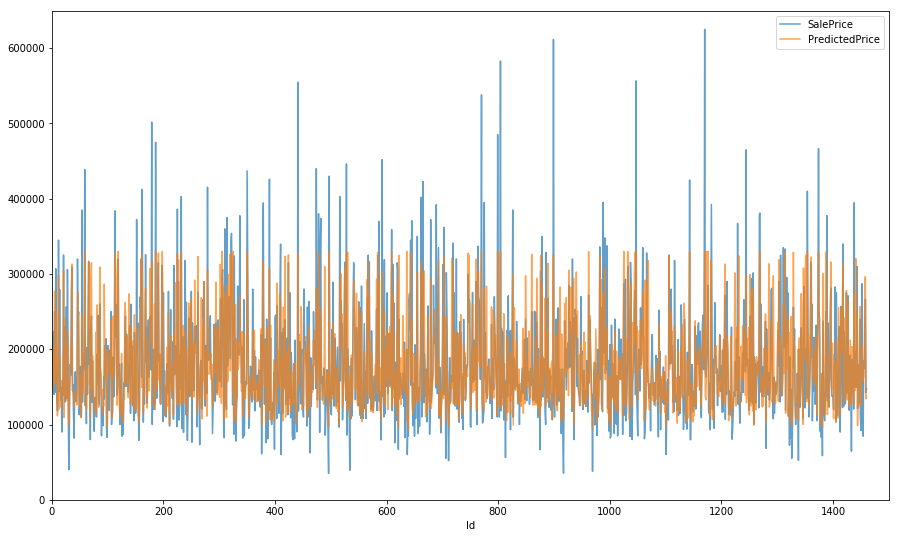

In [11]:
# regression analysis
X = train[attr].values # <-- '.values' unrequired if not gaussian
y = train['SalePrice']

# model = LinearRegression(fit_intercept=False)
# model = make_pipeline(PolynomialFeatures(3), LinearRegression())
# model = make_pipeline(GaussianFeatures(20), LinearRegression())
model = make_pipeline(GaussianFeatures(15), Ridge(alpha=0.01, max_iter=100))
# model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001, max_iter=1000))
model.fit(X, y)
train['PredictedPrice'] = model.predict(X)
train[['SalePrice', 'PredictedPrice']].plot(figsize=(15,9), alpha=0.7, xlim=(0,1500), ylim=(0,650000));

In [12]:
# check key parameters (LinearRegression)
# params = pd.Series(model.coef_, index=X.columns)
# err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)
# dferr = pd.DataFrame({'efeito': params.round(0), 'erro': err.round(0)})#; dferr

In [13]:
# check sale and predicted prices
pd.DataFrame.from_dict({'SalePrice': train['SalePrice'].describe(),
                        'PredictedPrice': train['PredictedPrice'].describe()})

,SalePrice,PredictedPrice
count,1456.00,1456.00
mean,180151.23,180151.23
std,76696.59,60479.80
min,34900.00,93754.45
25%,129900.00,133011.82
50%,163000.00,164099.25
75%,214000.00,212241.97
max,625000.00,330102.58


In [14]:
# predict house prices in test dataset
X_test = test[attr].values
test['SalePrice'] = model.predict(X_test)

In [15]:
# describe prediction
pd.DataFrame.from_dict({'PredictedSalePrice': test['SalePrice'].describe()})

,PredictedSalePrice
count,1459.00
mean,176589.68
std,60102.22
min,89898.96
25%,130229.74
50%,161805.16
75%,204249.26
max,330102.58


In [16]:
# write predicted values to output file
test['SalePrice'] = test['SalePrice'].astype(int)
test.to_csv('test_submission.csv', columns=['SalePrice'])
!cat test_submission.csv

Id,SalePrice
1461,119542
1462,138923
1463,180296
1464,177903
1465,158498
1466,180134
1467,157911
1468,165025
1469,162312
1470,126398
1471,167999
1472,127165
1473,128864
1474,148721
1475,129728
1476,304924
1477,199074
1478,223427
1479,248993
1480,330056
1481,295196
1482,175678
1483,170878
1484,160456
1485,163376
1486,196506
1487,317600
1488,204967
1489,166550
1490,185978
1491,187155
1492,101732
1493,179386
1494,300580
1495,283152
1496,188288
1497,189683
1498,156279
1499,156642
1500,158083
1501,169884
1502,152851
1503,183149
1504,212313
1505,187347
1506,237218
1507,316767
1508,214040
1509,165679
1510,136343
1511,134774
1512,168902
1513,183159
1514,219467
1515,319639
1516,141749
1517,146359
1518,180955
1519,188130
1520,125662
1521,129363
1522,176717
1523,126865
1524,116749
1525,116302
1526,119061
1527,119569
1528,137569
1529,128181
1530,157163
1531,177140
1532,99742
1533,140110
1534,133498
1535,170574
1536,113844
1537,107683
1538,145591
1539,280216
1540,273919
1541,139044
1542,164660
1543